In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import sys
print(sys.executable)

import math
import pandas as pd
from pandas import Timestamp
pd.set_option('display.max_columns', None)

import numpy as np
import glob
import os
import json

import datetime as dt
from datetime import datetime
from pprint import pprint
from collections import OrderedDict

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display, HTML
import seaborn as sns

from typing import Optional, Dict, Tuple, List, Sequence
from sklearn.preprocessing import StandardScaler

from tqdm.auto import tqdm
tqdm.pandas()        

pd.set_option('display.max_columns', None)


/usr/bin/python


[main] Found existing base CSV: dfs_training/AAPL_1_base.csv


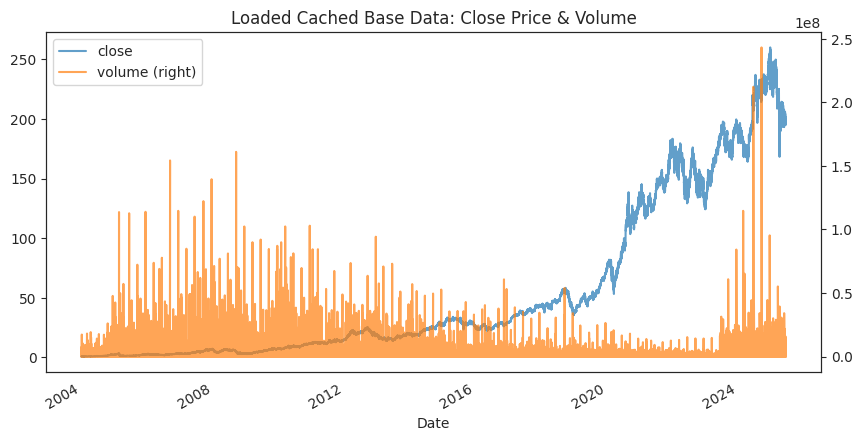

,open,high,low,close,volume,ask,bid
2004-01-02 09:00:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:01:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:02:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:03:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
2004-01-02 09:04:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764857,0.763714
...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.680000,196.860000,196.630000,196.815000,385695.0,196.962600,196.667400
2025-06-18 20:57:00,196.810000,196.940000,196.560000,196.675000,460630.0,196.822500,196.527500
2025-06-18 20:58:00,196.675000,196.740000,196.630000,196.670000,525245.0,196.817500,196.522500
2025-06-18 20:59:00,196.680000,196.750000,196.240000,196.240000,2075503.0,196.387200,196.092800


In [2]:
base_csv = params.base_csv

if os.path.exists(base_csv):
    # -----------------------------------------------------------------
    # 1) Cached file exists → load it, plot it, skip all processing.
    # -----------------------------------------------------------------
    print(f"[main] Found existing base CSV: {base_csv}")
    df = pd.read_csv(base_csv, index_col=0, parse_dates=True)
    plots.plot_close_volume(
        df,
        title="Loaded Cached Base Data: Close Price & Volume"
    )

else:
    # -----------------------------------------------------------------
    # 2) No cached file → do the full split‐adjust and then minute‐grid prep
    # -----------------------------------------------------------------
    print(f"[main] No base CSV found; running process_splits …")
    df_raw = trades.process_splits(
        folder              = params.stocks_folder,
        ticker              = params.ticker,
        bidasktoclose_pct   = params.bidasktoclose_pct
    )

    # Once‐only minute grid build and interpolation
    print(f"[main] Running prepare_interpolate_data …")
    df = trades.prepare_interpolate_data(
        df                = df_raw,
        sess_premark      = params.sess_premark,
        sess_start        = params.sess_start,
        sess_end          = params.sess_end
    )
    
    # Persist to base CSV and return
    df.to_csv(base_csv)
    print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [3]:
def process_single_day(day_str: str, best_optuna_params: dict):
    """
    Process and plot a single trading session using a given set of hyperparameters.

    Returns:
      Tuple[pd.DataFrame, Dict] | None
        If a valid backtest runs, returns (df_day, perf_day).
        If no data or no trades, returns None.
    """
    print(f"\n---------------------------------------------------------------------------------------------------------------------------------------------------\n")
    print(f"\n=== Processing trading day {day_str} ===")
    day_dt = pd.to_datetime(day_str)
    # Extract that day’s full-minute bars from the master df
    day_df = df.loc[df.index.normalize() == day_dt].copy()
    if day_df.empty:
        print(" no data; skipping.")
        return

    print("\n Running trading pipeline on selected date …")
    # Call run_trading_pipeline with your per-day slice + EXACTLY the same best_optuna_params
    result = trades.run_trading_pipeline(
                                        df                       = day_df,
                                        col_signal               = 'signal', # name for the signal column to use
                                        col_action               = 'signal_action', # name for the trade-action column to add
                                        day_to_check             = day_str,
                                        **best_optuna_params            # unpack tuned parameters here
    )
    if result is None:
        print(" no trades found; skipping.")
        return

    # Unpack pipeline output: (df_signals, trades_list, performance_stats)
    df_day, trades_day, perf_day = result

    # Plot the equity & trade markers
    plots.plot_trades(
                    df                 = df_day,
                    col_signal1        = 'signal',
                    col_signal2        = False,
                    col_action         = 'signal_action',
                    trades             = trades_day,
                    buy_threshold      = best_optuna_params['buy_threshold'],
                    performance_stats  = perf_day,
                    start_plot         = params.sess_start # or sess_premark 
    )

    # Print the per-day summary
    print(f"\n* Performance for {day_dt.date()} *")
    for k, v in perf_day.items():
        print(f"  {k}: {v}")

    return df_day, perf_day


In [4]:
def saveDF_checkDAY(df: pd.DataFrame, best_optuna_params: dict):
    """
    Backtest in two modes and optionally save a full‐run CSV of signals,
    using the supplied hyperparameters.

    Modes:
      • Month mode (params.date_to_check = 'YYYY-MM'):
          – process each trading day via process_single_day(..., best_optuna_params)
          – plot monthly aggregate performance
          – return the month’s concatenated DataFrame (empty if none)

      • Full‐run mode (params.createCSVsign == True):
          – run the identical pipeline used by Optuna over all days
            with **best_optuna_params
          – compute & print the full‐period summary
          – plot full‐period performance
          – isolate & compute the test‐period summary
          – plot test‐period performance
          – save the dataframe with the calculated signal
          – return the full‐run DataFrame
    """
    keep_cols = [
        "open","high","low","close",
        "volume","bid","ask",
        "StrategyEarning","EarningDiff",
        "signal","signal_action"
    ]

    # ── Month mode ────────────────────────────────────────────────────
    print(f"\nMonth mode: processing {params.date_to_check}")
    month_days = (
                df.loc[df.index.strftime("%Y-%m") == params.date_to_check]
                  .index.normalize()
                  .unique()
    )

    month_frames, month_stats = [], []
    for day in sorted(month_days):
        # Pass best_optuna_params into process_single_day
        res = process_single_day(day_str = str(day.date()), 
                                 best_optuna_params = best_optuna_params)
        
        if res is None:
            continue
        df_day, stats = res
        month_frames.append(df_day)
        month_stats.append(stats)

    if not month_frames:
        print("No valid days in this month.")
        return pd.DataFrame(columns=keep_cols)

    df_month = pd.concat(month_frames).sort_index()
    plots.aggregate_performance(month_stats, df_month)

    # If we aren’t saving a full-run CSV, bail out
    if not params.createCSVsign:
        return df_month

    # ── Full‐run mode ────────────────────────────────────────────────
    print("\nFull‐run mode")
    print("• Running trading pipeline on full dataset …")
    # Unpack best_optuna_params into run_trading_pipeline exactly as in Optuna
    full_sim_results = trades.run_trading_pipeline(
                                                    df            = df,
                                                    col_signal    = 'signal',
                                                    col_action    = 'signal_action',
                                                    **best_optuna_params
    )

    # 1) Build combined DF & perf list (zeros on no‐trade days)
    daily_frames = [res[0][keep_cols] for res in full_sim_results.values()]
    df_all       = pd.concat(daily_frames).sort_index()
    perf_all     = [res[2] for res in full_sim_results.values()]

    # 2) Print & plot full‐period performance using df_all
    print("\nFull‐period performance:")
    plots.aggregate_performance(perf_all, df_all)

    # 3) Test‐period slice & plot
    days_all  = df_all.index.normalize().unique()
    cutoff    = int(len(days_all) * (params.train_prop + params.val_prop))
    test_days = days_all[cutoff:]
    df_test   = df_all[df_all.index.normalize().isin(test_days)]
    perf_test = [
        stats
        for day, (_, _, stats) in full_sim_results.items()
        if pd.Timestamp(day).normalize() in test_days
    ]

    print("\nTest‐period performance:")
    plots.aggregate_performance(perf_test, df_test)

    # Save the full-run signals CSV
    print("\n• Saving signals CSV …")
    df_all.to_csv(params.sign_csv)
    print(f"Saved to {params.sign_csv}")

    return df_all


best_optuna_value: 0.31821574074074077
best_optuna_params: {'min_prof_thr': 0.04265038778196016, 'max_down_prop': 0.26635351911319244, 'gain_tightening_factor': 5.3884710440751205, 'merging_retracement_thr': 0.42298663064410114, 'merging_time_gap_thr': 2.496420698992321, 'pre_entry_decay': 0.030068981408743638, 'short_penal_decay': 5.617020277469004, 'trailing_stop_pct': 0.11171164939451203, 'buy_threshold': 0.4030644008589517, 'top_percentile': 3.709798666150449, 'smoothing_window': 60}

Month mode: processing 2023-09

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-01 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2023-09-01 *
  Buy & Hold Return ($): -0.449
  Strategy Return ($): -0.424
  Trades Returns ($): [-0.729, 0.1, 0.206]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-05 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2023-09-05 *
  Buy & Hold Return ($): 1.167
  Strategy Return ($): 0.274
  Trades Returns ($): [0.742, 0.146, -0.015, -0.6]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-06 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2023-09-06 *
  Buy & Hold Return ($): -5.819
  Strategy Return ($): -0.277
  Trades Returns ($): [0.313, -0.212, -0.234, -0.145]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-07 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2023-09-07 *
  Buy & Hold Return ($): 2.935
  Strategy Return ($): 2.98
  Trades Returns ($): [2.331, 0.65]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-08 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2023-09-08 *
  Buy & Hold Return ($): -0.968
  Strategy Return ($): -0.187
  Trades Returns ($): [-0.179, -0.009]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-11 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2023-09-11 *
  Buy & Hold Return ($): -1.007
  Strategy Return ($): 0.069
  Trades Returns ($): [0.082, 0.195, -0.21]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-12 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2023-09-12 *
  Buy & Hold Return ($): -3.195
  Strategy Return ($): -1.023
  Trades Returns ($): [0.055, -0.443, -0.635]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-13 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2023-09-13 *
  Buy & Hold Return ($): -2.836
  Strategy Return ($): -0.174
  Trades Returns ($): [0.009, -0.182]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-14 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2023-09-14 *
  Buy & Hold Return ($): 1.605
  Strategy Return ($): 1.477
  Trades Returns ($): [1.185, 0.235, 0.056]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-15 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2023-09-15 *
  Buy & Hold Return ($): -1.198
  Strategy Return ($): 0.349
  Trades Returns ($): [0.349]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-18 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2023-09-18 *
  Buy & Hold Return ($): 0.72
  Strategy Return ($): -0.151
  Trades Returns ($): [-0.151]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-19 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2023-09-19 *
  Buy & Hold Return ($): 1.127
  Strategy Return ($): 0.249
  Trades Returns ($): [-0.286, -0.016, 0.552]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-20 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2023-09-20 *
  Buy & Hold Return ($): -4.101
  Strategy Return ($): -0.943
  Trades Returns ($): [-0.808, -0.137]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-21 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2023-09-21 *
  Buy & Hold Return ($): -1.562
  Strategy Return ($): 0.037
  Trades Returns ($): [0.037]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-22 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2023-09-22 *
  Buy & Hold Return ($): 0.358
  Strategy Return ($): 2.499
  Trades Returns ($): [2.328, 0.172]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-25 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2023-09-25 *
  Buy & Hold Return ($): 0.94
  Strategy Return ($): 0.924
  Trades Returns ($): [1.2, -0.718, 0.443]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-26 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2023-09-26 *
  Buy & Hold Return ($): -3.04
  Strategy Return ($): -0.856
  Trades Returns ($): [-0.47, -0.386]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-27 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2023-09-27 *
  Buy & Hold Return ($): -2.852
  Strategy Return ($): 0.004
  Trades Returns ($): [-0.677, 0.681]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-28 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2023-09-28 *
  Buy & Hold Return ($): 2.376
  Strategy Return ($): 3.608
  Trades Returns ($): [3.485, 0.123]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-29 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2023-09-29 *
  Buy & Hold Return ($): -1.258
  Strategy Return ($): 0.139
  Trades Returns ($): [0.122, 0.017]

Overall Summary (2023-09-01 = 189.7672 → 2023-09-29 = 171.0116)

One-time buy&hold gain: -18.756
Buy & Hold – each day ($): -17.057
Strategy Return ($): 8.574
Trades Count: 47
Strategy return per trade: 0.182
Num. trading days: 20
Strategy return per trading day: 0.429


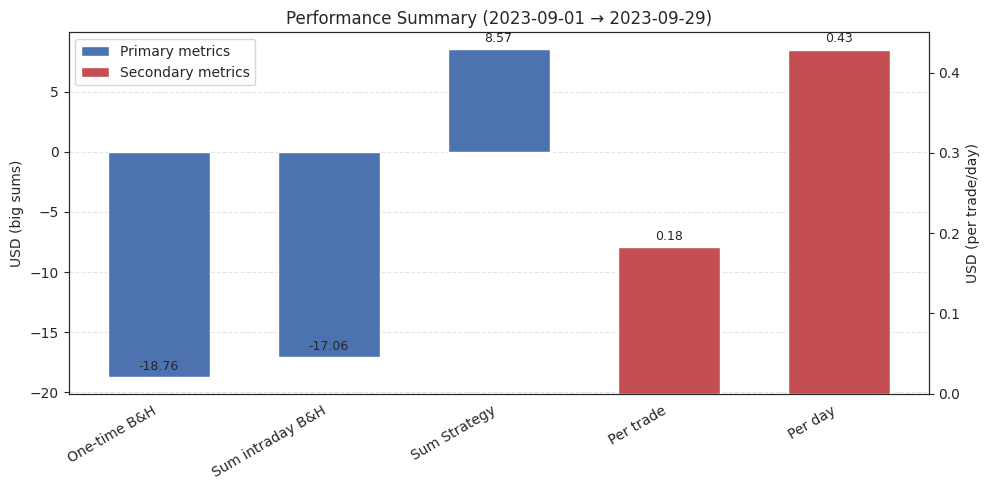


Full‐run mode
• Running trading pipeline on full dataset …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


Simulating trading days: 100%|██████████| 5400/5400 [02:59<00:00, 30.02day/s]



Full‐period performance:

Overall Summary (2004-01-02 = 0.7731 → 2025-06-18 = 196.3926)

One-time buy&hold gain: 195.620
Buy & Hold – each day ($): -385.278
Strategy Return ($): 1718.364
Trades Count: 9029
Strategy return per trade: 0.190
Num. trading days: 5400
Strategy return per trading day: 0.318


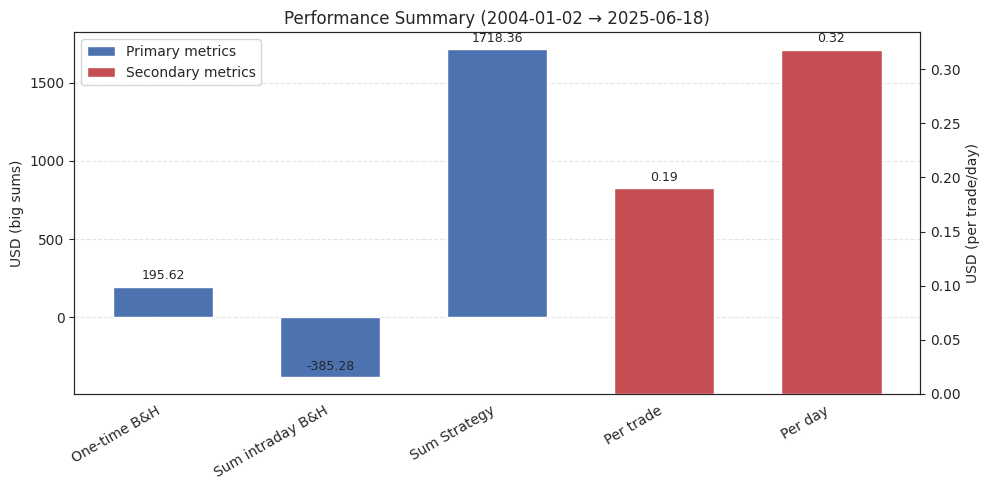


Test‐period performance:

Overall Summary (2022-03-28 = 172.8295 → 2025-06-18 = 196.3926)

One-time buy&hold gain: 23.563
Buy & Hold – each day ($): -189.487
Strategy Return ($): 867.371
Trades Count: 1380
Strategy return per trade: 0.629
Num. trading days: 810
Strategy return per trading day: 1.071


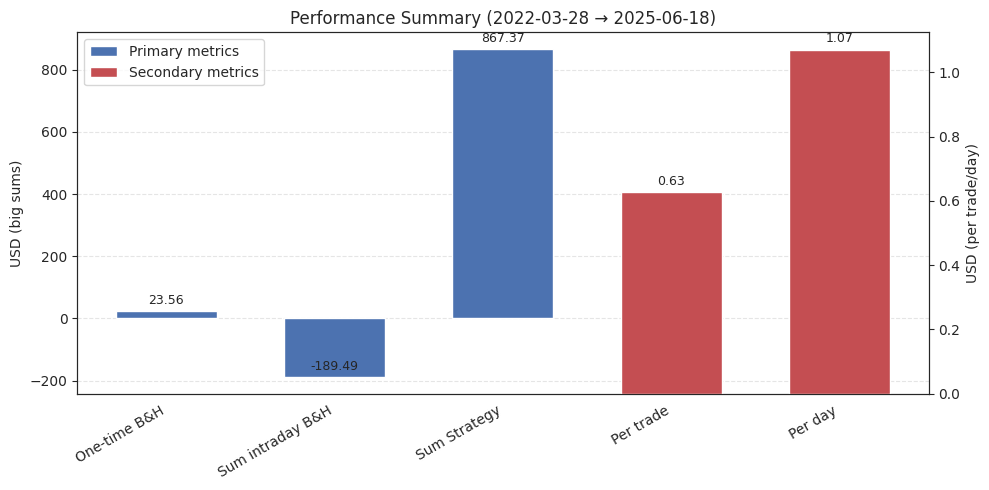


• Saving signals CSV …
Saved to dfs_training/AAPL_2_sign.csv


,open,high,low,close,volume,bid,ask,StrategyEarning,EarningDiff,signal,signal_action
2004-01-02 09:00:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.763714,0.764857,0.000,0.000,0.000389,0
2004-01-02 09:01:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.763714,0.764857,0.000,0.000,0.000396,0
2004-01-02 09:02:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.763714,0.764857,0.000,0.000,0.000403,0
2004-01-02 09:03:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.763714,0.764857,0.000,0.000,0.000410,0
2004-01-02 09:04:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.763714,0.764857,0.000,0.000,0.000417,0
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.680000,196.860000,196.630000,196.815000,385695.0,196.667400,196.962600,2.242,1.642,0.589796,0
2025-06-18 20:57:00,196.810000,196.940000,196.560000,196.675000,460630.0,196.527500,196.822500,2.102,1.641,0.590466,0
2025-06-18 20:58:00,196.675000,196.740000,196.630000,196.670000,525245.0,196.522500,196.817500,2.097,1.641,0.586079,0
2025-06-18 20:59:00,196.680000,196.750000,196.240000,196.240000,2075503.0,196.092800,196.387200,1.667,1.641,0.576345,0


In [5]:
print('best_optuna_value:', params.best_optuna_value)
print('best_optuna_params:', params.best_optuna_params)

df_fin = saveDF_checkDAY(
                        df=df,
                        best_optuna_params=params.best_optuna_params
                        )

df_fin

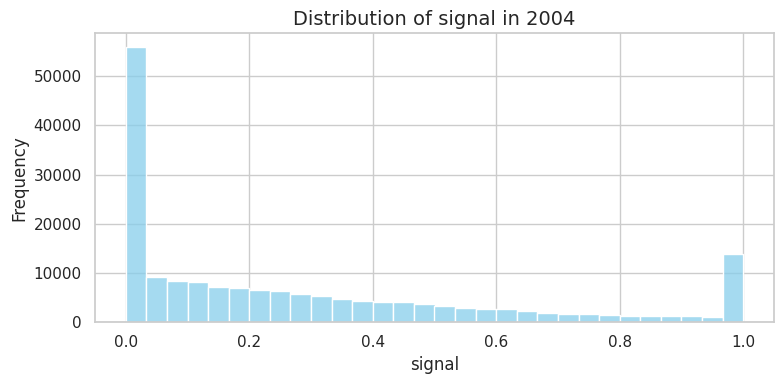

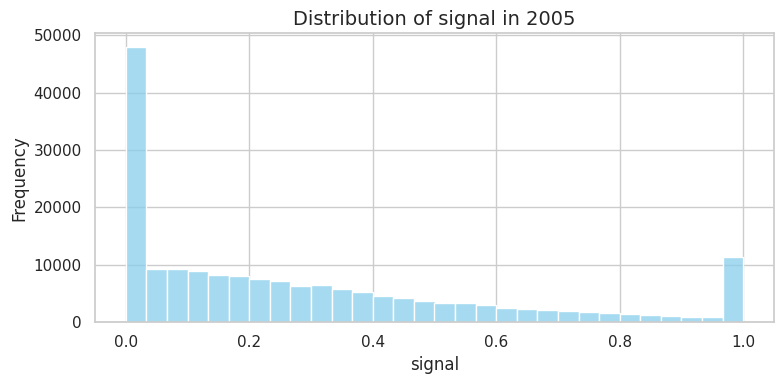

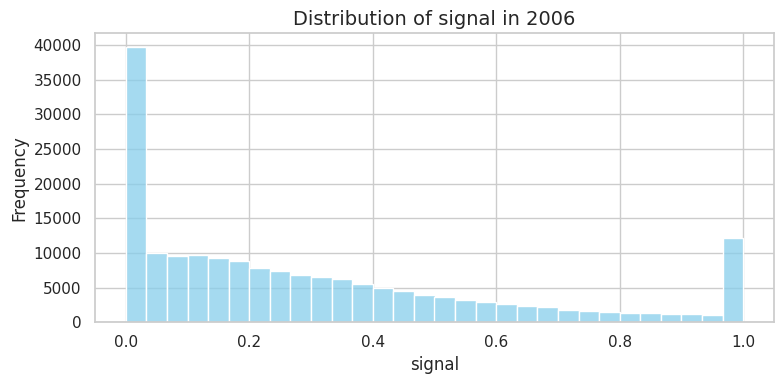

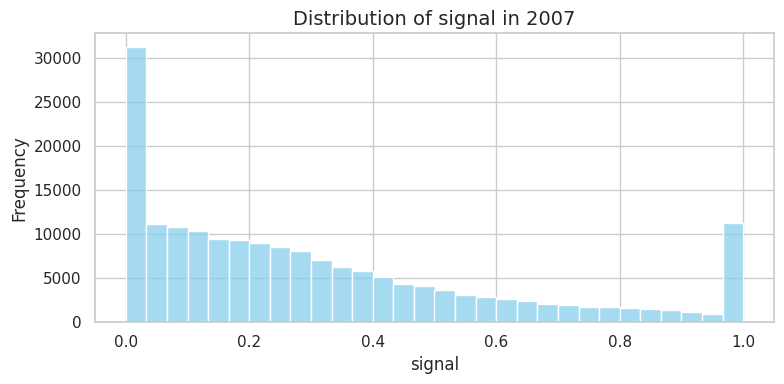

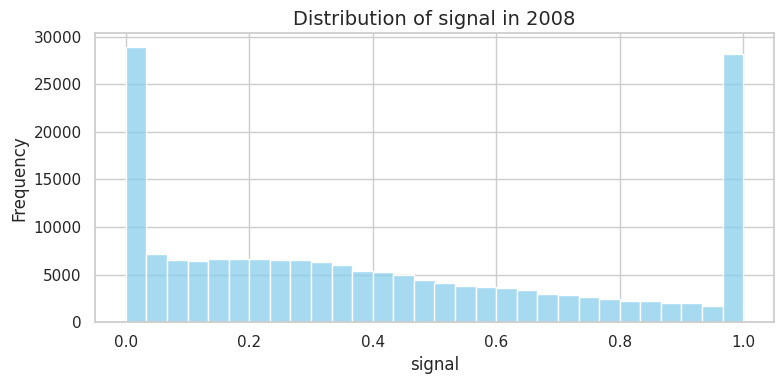

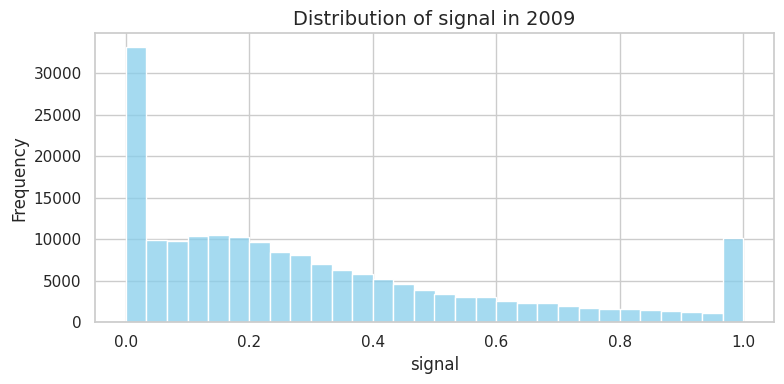

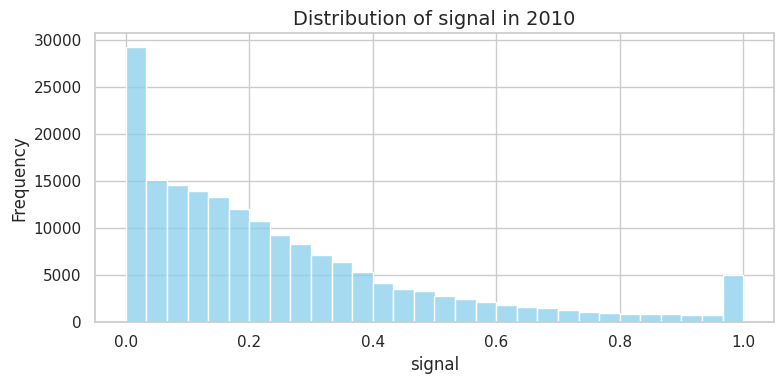

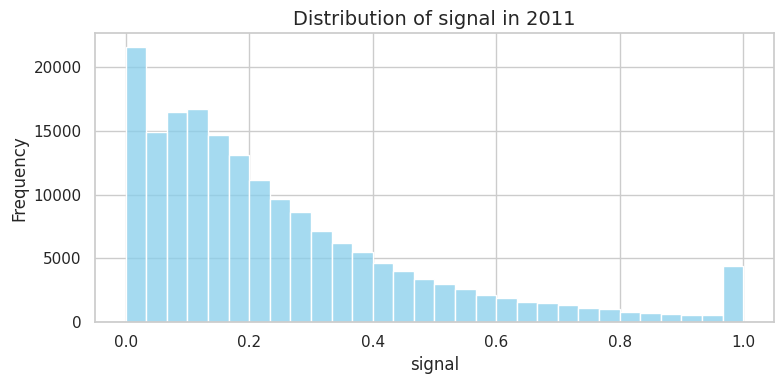

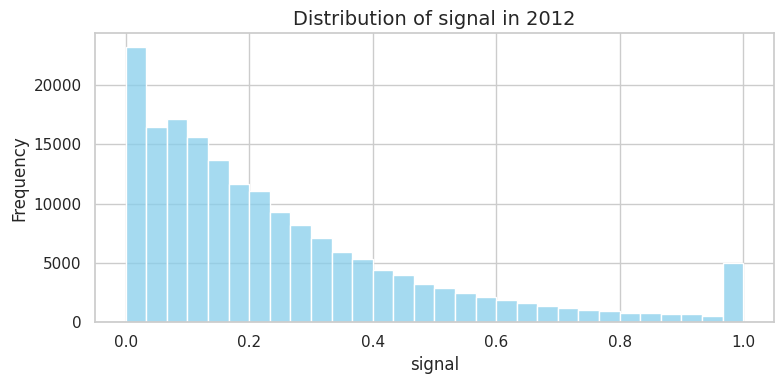

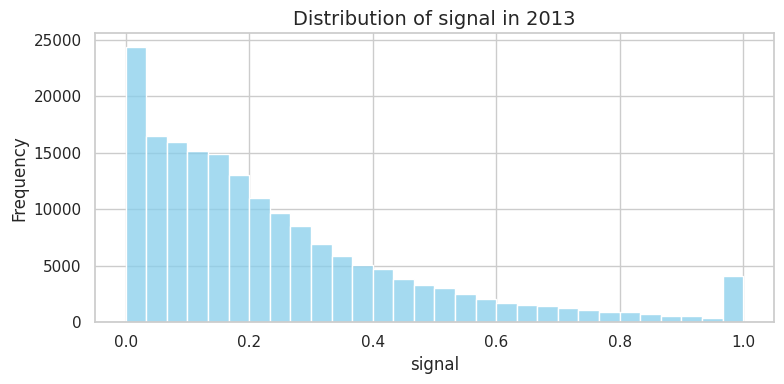

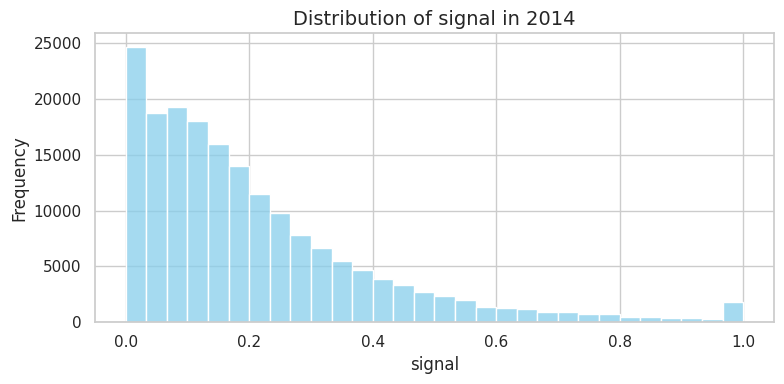

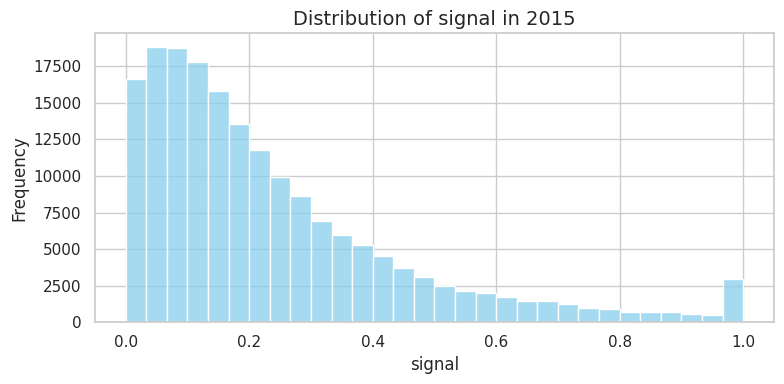

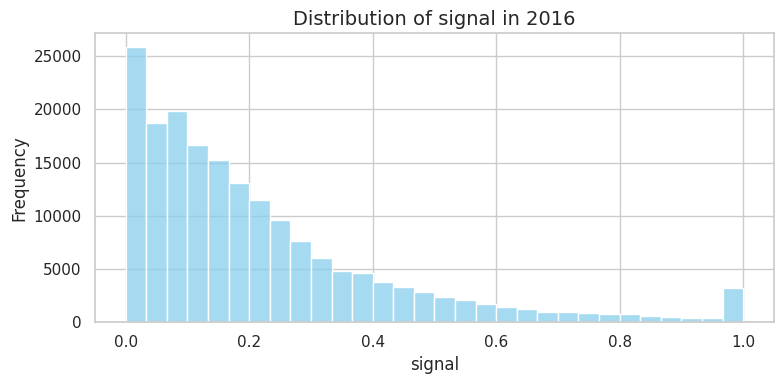

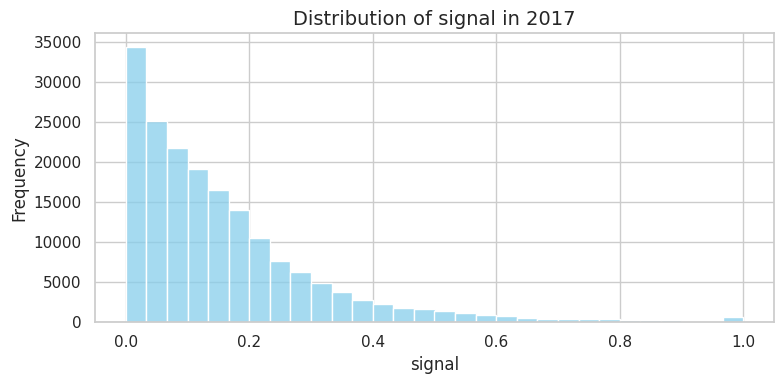

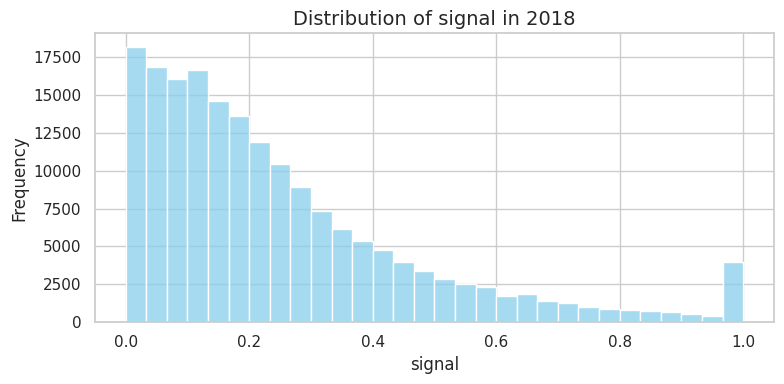

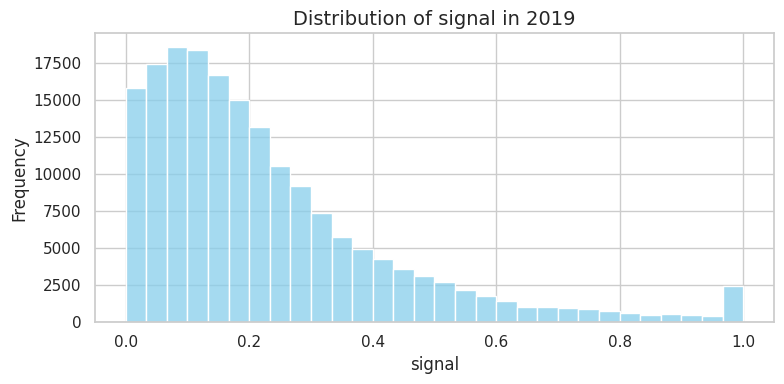

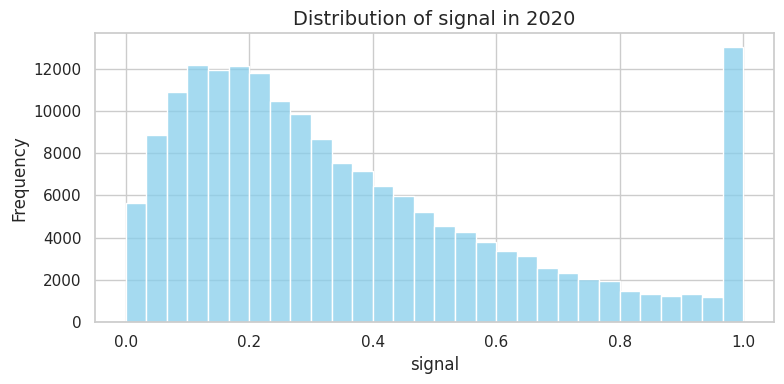

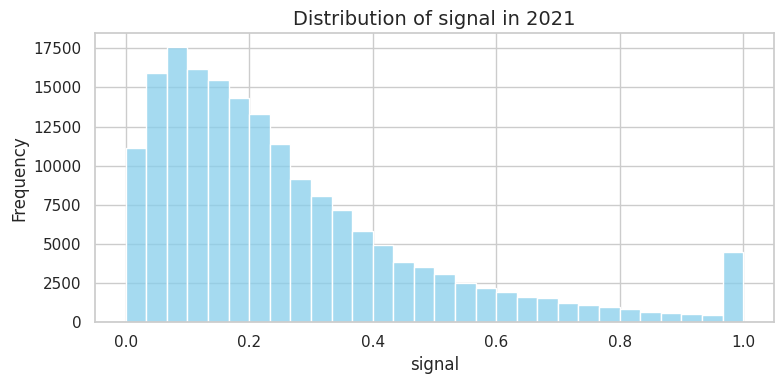

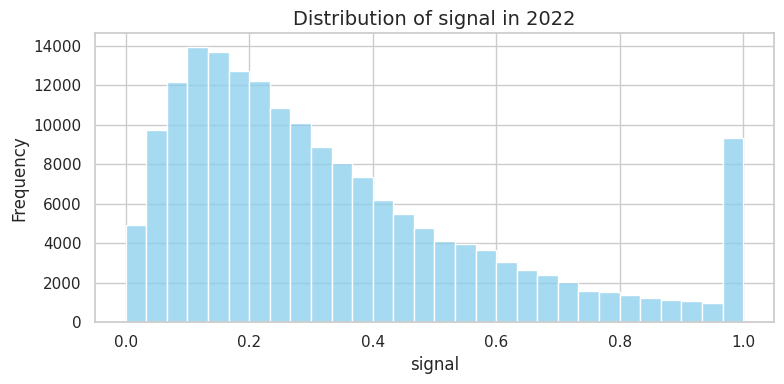

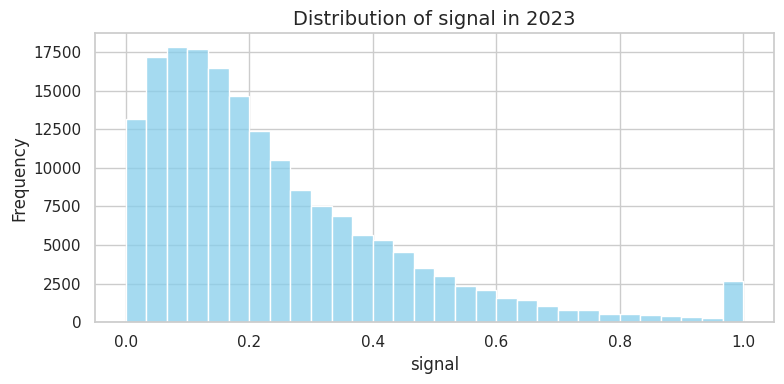

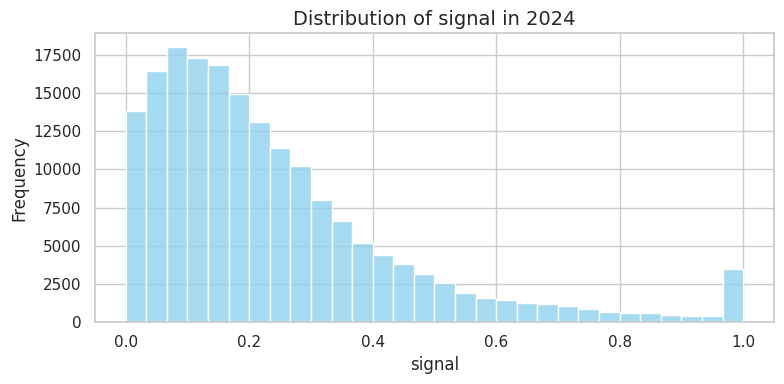

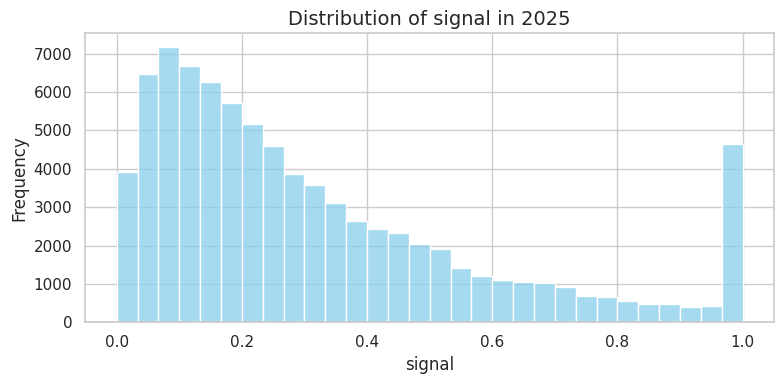

,signal_min,signal_max,signal_mean,signal_median,close_return
2004-01,0.000000e+00,1.000000,0.293632,0.197897,0.170916
2004-02,0.000000e+00,1.000000,0.244084,0.141128,0.105893
2004-03,0.000000e+00,1.000000,0.298831,0.186791,0.196335
2004-04,0.000000e+00,1.000000,0.272496,0.162605,0.156863
2004-05,0.000000e+00,1.000000,0.295598,0.165969,0.127743
2004-06,7.548646e-09,1.000000,0.295639,0.180322,0.241579
2004-07,0.000000e+00,1.000000,0.300454,0.189289,0.161862
2004-08,0.000000e+00,1.000000,0.302058,0.180322,0.182185
2004-09,0.000000e+00,1.000000,0.274982,0.160773,0.145439
2004-10,0.000000e+00,1.000000,0.299078,0.177248,0.409440


In [6]:
pd.set_option('display.max_rows', None)

# Group by month
period = df_fin.index.to_period('M')

# Monthly stats for signal
signal_stats = df_fin.groupby(period)['signal'].agg(
    signal_min='min',
    signal_max='max',
    signal_mean='mean',
    signal_median='median'
)

# Monthly close return: (max - min) / min
close_return = df_fin.groupby(period)['close'].agg(
    close_return=lambda x: np.nan if x.min() == 0 else (x.max() - x.min()) / x.min()
)

# Combine into one DataFrame
monthly_stats = signal_stats.join(close_return)


# --------------------------------------------------
# Now plot histograms of signal for each year
# --------------------------------------------------

sns.set(style="whitegrid")
unique_years = sorted(df_fin.index.year.unique())

for y in unique_years:
    subset = df_fin[df_fin.index.year == y]['signal']
    
    plt.figure(figsize=(8, 4))
    sns.histplot(subset, bins=30, kde=False, color="skyblue")
    plt.title(f"Distribution of signal in {y}", fontsize=14)
    plt.xlabel("signal", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.tight_layout()
    plt.show()

monthly_stats
